 **Problem 2**


https://colab.research.google.com/drive/1eLLhRCl2VRY00EJVoeFaij5-r2QVl_0I


You must download the minst data set from git and upload it to your google drive:

https://github.com/jonPlante/IFT6135_Ass1)

In [ ]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# load data
with gzip.open('/content/gdrive/My Drive/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')


In [ ]:
#install pytorch
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [0]:
#convert data in to pytorch format

mnist_train=[]
mnist_valid=[]
mnist_test=[]
for i in range(len(train_set[0])):
  x=torch.Tensor(train_set[0][i].reshape((1,28,28)))
  mnist_train.append([x,train_set[1][i]])
  
for i in range(len(valid_set[0])):
  x=torch.Tensor(valid_set[0][i].reshape((1,28,28)))
  mnist_valid.append([x,valid_set[1][i]])

for i in range(len(test_set[0])):
  x=torch.Tensor(test_set[0][i].reshape((1,28,28)))
  mnist_test.append([x,test_set[1][i]])

# CNN Architecture

The first layer is 120 kernels with size of 4x4 with 1 channel (1920 parameters). The activation is Relu followed by with a non overlapping max pool layer of 2x2.

The second layer is 300 kernels with size 4x4 with 120 channels (576, 000 parameters). The activation is Relu followed by a non overlapping max pool layer of 2x2.

We then have a fully connected layer with bias of 20 neurons with 4800 inputs (96, 020 parameters). The activation is Relu.

Finally we have a second fully connected with bias layer of 10 neurons with 20 inputs (210 parameters) leading to the outputs.

The total amount of parameters is 674, 150 = 0.67415 M. 

The mini batch size is 50 and the learning rate 0.01.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 120, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(120, 300, 4)
        self.fc1 = nn.Linear(300 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 300 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [ ]:
epochs=10
MB=50
LR=0.01
# using cuda
use_cuda = True
net = Net()
if use_cuda and torch.cuda.is_available():
    net.cuda()
    print('using cuda')
else:
  print('not using cuda')

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=MB,shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(mnist_valid, batch_size=MB,shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=MB,shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.0)
train_data=np.zeros((epochs+1,3))
valid_data=np.zeros((epochs+1,3))

print('Calculating initial training loss')
total_loss = 0.0
total_error=0
for i, data in enumerate(trainloader, 0):
  # get the inputs
  images, labels = data
  images=Variable(images)
  labels=Variable(labels)
  if use_cuda and torch.cuda.is_available():
    images = images.cuda()
    labels = labels.cuda()
  outputs = net(images)
  loss = criterion(outputs, labels)
  total_error+=np.sum(np.minimum(np.abs((torch.max(outputs,1)[1]-labels).data.cpu().numpy()),1))
  total_loss+=loss.data.cpu()
  if i*MB%10000==0 and not i==0:
    print('\t'+str(np.round(i*MB/50000*100,2))+'% complete')
train_data[0,:]=[0,total_loss/(50000/MB),total_error/50000]
print('Initial training loss: ' +str(np.round(train_data[0,1],2))+', training error: '+str(np.round(train_data[0,2]*100,2))+'%, training accuracy:'+str(np.round((1-train_data[0,2])*100,2))+'%')

print('Calculating initial validation loss')
total_loss = 0.0
total_error=0
for i, data in enumerate(validloader, 0):
  # get the inputs
  images, labels = data
  images=Variable(images)
  labels=Variable(labels)
  if use_cuda and torch.cuda.is_available():
    images = images.cuda()
    labels = labels.cuda()
  outputs = net(images)
  loss = criterion(outputs, labels)
  total_error+=np.sum(np.minimum(np.abs((torch.max(outputs,1)[1]-labels).data.cpu().numpy()),1))
  total_loss+=loss.data.cpu()
valid_data[0,:]=[0,total_loss/(10000/MB),total_error/10000]
print('Initial validation loss: ' +str(np.round(valid_data[0,1],2))+', validation error: '+str(np.round(valid_data[0,2]*100,2))+'%, validation accuracy:'+str(np.round((1-valid_data[0,2])*100,2))+'%')

for epoch in range(epochs):  # loop over the dataset multiple times
  running_loss = 0.0
  num_ex=0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    images, labels = data
    images=Variable(images)
    labels=Variable(labels)
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.data.cpu().numpy()
    num_ex+=1
    if i*MB%10000 == 0 and not i==0:
      print('\tLoss: '+str(np.round(running_loss/num_ex,3))+', '+str(np.round(i*MB/50000*100,2))+'% of epoch ' + str(epoch+1) +' complete')
      num_ex=0
      running_loss=0
  print('Epoch '+str(epoch+1) + ' complete')
            
  print('Calculating training loss')
  total_loss = 0.0
  total_error=0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    images, labels = data
    images=Variable(images)
    labels=Variable(labels)
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = net(images)
    loss = criterion(outputs, labels)
    total_error+=np.sum(np.minimum(np.abs((torch.max(outputs,1)[1]-labels).data.cpu().numpy()),1))
    total_loss+=loss.data.cpu()
    if i*MB%10000==0 and not i==0:
      print('\t'+str(np.round(i*MB/50000*100,2))+'% complete')
  train_data[epoch+1,:]=[epoch+1,total_loss/(50000/MB),total_error/50000]
  print('Training loss: ' +str(np.round(train_data[epoch+1,1],2))+', training error: '+str(np.round(train_data[epoch+1,2]*100,2))+'%, training accuracy:'+str(np.round((1-train_data[epoch+1,2])*100,2))+'%')

  print('Calculating validation loss')
  total_loss = 0.0
  total_error=0
  for i, data in enumerate(validloader, 0):
    # get the inputs
    images, labels = data
    images=Variable(images)
    labels=Variable(labels)
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = net(images)
    loss = criterion(outputs, labels)
    total_error+=np.sum(np.minimum(np.abs((torch.max(outputs,1)[1]-labels).data.cpu().numpy()),1))
    total_loss+=loss.data.cpu()
  valid_data[epoch+1,:]=[epoch+1,total_loss/(10000/MB),total_error/10000]
  print('Validation loss: ' +str(np.round(valid_data[epoch+1,1],2))+', validation error: '+str(np.round(valid_data[epoch+1,2]*100,2))+'%, validation accuracy:'+str(np.round((1-valid_data[epoch+1,2])*100,2))+'%')
         
print('Finished Training')
torch.cuda.empty_cache()
            
print('Calculating performance on test set')
total_error=0
for i, data in enumerate(testloader, 0):
# get the inputs
  images, labels = data
  images=Variable(images)
  labels=Variable(labels)
  if use_cuda and torch.cuda.is_available():
    images = images.cuda()
    labels = labels.cuda()
  outputs = net(images)
  total_error+=np.sum(np.minimum(np.abs((torch.max(outputs,1)[1]-labels).data.cpu().numpy()),1))
      
print('Test error: '+str(np.round(total_error/10000*100,2))+'%, test accuracy:'+str(np.round((1-total_error/10000)*100,2))+'%')
         

# CNN vs MLP


Plotting results



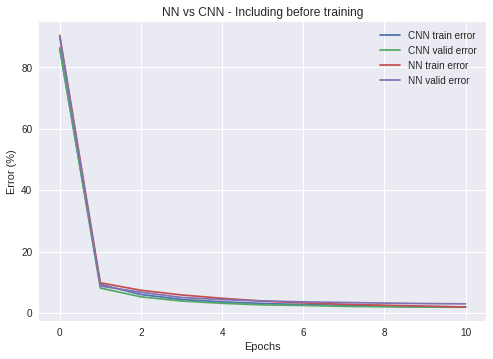


Plotting results



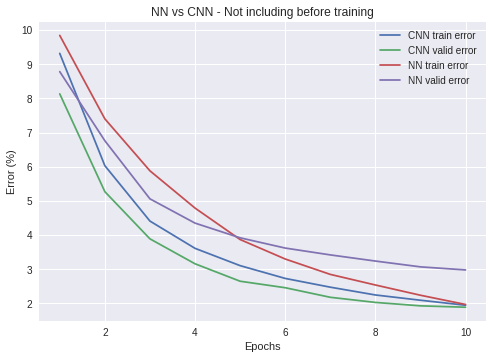

In [0]:
NN_data_train=np.array([90.32,9.84,7.40,5.88,4.79,3.87,3.30,2.85,2.54,2.24,1.97])
NN_data_valid=np.array([89.91,8.78,6.76,5.06,4.35,3.92,3.62,3.42,3.24,3.07,2.98])
print('\nPlotting results\n')
plt.plot(train_data[:,0],train_data[:,2]*100,label='CNN train error')
plt.plot(valid_data[:,0],valid_data[:,2]*100,label='CNN valid error')
plt.plot(train_data[:,0],NN_data_train,label='NN train error')
plt.plot(valid_data[:,0],NN_data_valid,label='NN valid error')
plt.title('NN vs CNN - Including before training')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

print('\nPlotting results\n')
plt.plot(train_data[1:,0],train_data[1:,2]*100,label='CNN train error')
plt.plot(valid_data[1:,0],valid_data[1:,2]*100,label='CNN valid error')
plt.plot(train_data[1:,0],NN_data_train[1:],label='NN train error')
plt.plot(valid_data[1:,0],NN_data_valid[1:],label='NN valid error')
plt.title('NN vs CNN - Not including before training')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

CNN= Convolutional Neural Network, NN= Multi Layer Perceptron

From the graphs above, one can see that the CNN error rate drops faster. We can also see that the the generalisation gap between the validation error and training error for the CNN after 10 epochs is very small (less than 0.1%) while the gap between the training error and validation error for the NN is much bigger (about 1%).  We also see that the NN and CNN training error after 10 epochs is 2%, while the validation error for CNN is 2% and for NN is 3%.

Finally, the test error on CNN was 2% while on NN it was about 3%. This shows that the CNN generalises better that the NN for images since the test, validation and training error are all the same. While in the NN the test and validation error increased by 1% from the training error. 